In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"
# Scikit-Learn imports
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold,
                                     learning_curve, StratifiedShuffleSplit, cross_val_score, cross_validate,
                                      RepeatedStratifiedKFold, cross_val_predict)
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, SGDClassifier, LogisticRegression, Perceptron
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Other imports
import numpy as np
np.random.seed(5)
import math
from scipy import stats
from scipy.stats import randint, loguniform
import os
import pandas as pd
from pandas.plotting import scatter_matrix


import joblib

# Plotting imports
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
plt.rcParams.update({'font.size':12})
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
random_state=5

In [2]:
def initial_evaluation(y_test, predictions, predictions_prob):
    data = confusion_matrix(y_test, predictions)
    df = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
    df.index.name = 'Actual'
    df.columns.name = 'Predicted'
    plt.figure(figsize = (10,4))
    sns.heatmap(df, cmap="Blues", annot=True, fmt='g')# font size
    plt.show()

    auc_test = roc_auc_score(y_test, predictions_prob)
    print('AUC:' ,auc_test)  

    accuracy_test = metrics.accuracy_score(y_test, predictions)
    print('Accuracy', accuracy_test)

    precision_test = metrics.precision_score(y_test, predictions)
    print('Precision', precision_test)

    recall_test = metrics.recall_score(y_test, predictions)
    print('Recall', recall_test)

    score = metrics.f1_score(y_test, predictions)
    print("F1 Score:", score)

In [3]:
def classification_evaluation(model, X_train, y_train, cv):
    predictions = cross_val_predict(model, X_train, y_train, cv=3)
    data = confusion_matrix(y_train, predictions)

    df = pd.DataFrame(data, columns=np.unique(y_train), index = np.unique(y_train))
    df.index.name = 'Actual'
    df.columns.name = 'Predicted'
    plt.figure(figsize = (10,4))
    sns.heatmap(df, cmap="Blues", annot=True, fmt='g')# font size
    plt.show()
    
    print("Accuracy:", accuracy_score(y_train, predictions))
    print("Precision:", precision_score(y_train, predictions))
    print("Recall:", recall_score(y_train, predictions))

    score = metrics.f1_score(y_train, predictions)
    print("F1 Score:", score)

    proba = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')
    probs = proba[:, 1]


    fpr, tpr, _ = metrics.roc_curve(y_train, probs)

    # This is the ROC curve
    plt.plot(fpr, tpr, label='line', color='c')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.show() 

    log_auc = metrics.roc_auc_score(y_train, probs)
    print("AUC:",log_auc)

In [4]:
def final_evaluation(model, X_test, y_test):
    
    predictions = model.predict(X_test)
        
    data = confusion_matrix(y_test, predictions)
    df = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
    df.index.name = 'Actual'
    df.columns.name = 'Predicted'
    plt.figure(figsize = (10,4))
    sns.heatmap(df, cmap="Blues", annot=True, fmt='g')# font size
    plt.show()  

    accuracy_test = metrics.accuracy_score(y_test, predictions)
    print('Accuracy', accuracy_test)

    precision_test = metrics.precision_score(y_test, predictions)
    print('Precision', precision_test)

    recall_test = metrics.recall_score(y_test, predictions)
    print('Recall', recall_test)

    score = metrics.f1_score(y_test, predictions)
    print("F1 Score:", score)

    proba = model.predict_proba(X_test)
    probs = proba[:, 1]


    fpr, tpr, _ = metrics.roc_curve(y_test, probs)

    # This is the ROC curve
    plt.plot(fpr, tpr, label='line', color='c')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate or (1 - Specifity)')
    plt.ylabel('True Positive Rate or (Sensitivity)')
    plt.title('Receiver Operating Characteristic')
    plt.show() 

    log_auc = roc_auc_score(y_test, probs)
    print("AUC:",log_auc)

# 1. Frame the Problem

How does the company expect to use and benefit from this model?
- The company hopes to **predict churn behaviour** in order to retain customers and revenue.
- Off the back of this model, retention campaigns will be run to **target identified potential churners**.

This will help to frame the problem, determine which algorithms to select and performance measures used to evalute the model, and now much effort you'll spend tweaking it.

What does the current solution look like (if any)?
- Manual selection of customers who they percieve to be at risk and then targetting them in a camapign, which is very **time consuming** and often not good at identifying potential churners.

This problem is a:
- a **supervised learning** problem since we have labelled training examples
- a **classification** problem since we have to predict a class **churn or no churn**
- it is also **batch learning** as there is no continuous flow of data

# 2. Get the Data

In [5]:
telco = pd.read_csv('datasets/telco/WA_Fn-UseC_-Telco-Customer-Churn.csv')
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [6]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Having inspected some of the data, some categoric data is marked with 1/0 and others Yes/No e.g SeniorCitizen is categoric but numeric dtype.

It is effectively already one hot encoded(OHE), but as I want to do OHE to other categories in a pipeline, I will convert 1 and 0 to Yes and No.

In [7]:
# replace numeric to object values for categoric data
telco['SeniorCitizen'].replace({1:'Yes', 0:'No'}, inplace=True)

In [8]:
# convert total charges to float from object
telco['TotalCharges'] = telco.TotalCharges.replace(' ', np.nan)
telco['TotalCharges'] = telco.TotalCharges.astype('float')

In [9]:
# convert churn Yes No to 1 0
telco['Churn'] = telco['Churn'].map(dict(Yes=1, No=0))

In [10]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [11]:
telco.describe()

,tenure,MonthlyCharges,TotalCharges,Churn
count,7043.000000,7043.000000,7032.000000,7043.000000
mean,32.371149,64.761692,2283.300441,0.265370
std,24.559481,30.090047,2266.771362,0.441561
min,0.000000,18.250000,18.800000,0.000000
25%,9.000000,35.500000,401.450000,0.000000
50%,29.000000,70.350000,1397.475000,0.000000
75%,55.000000,89.850000,3794.737500,1.000000
max,72.000000,118.750000,8684.800000,1.000000


There are 3 actually numeric features in the data: tenure, monthly charges and total charges.

## 2a. Quick view of what the data looks like

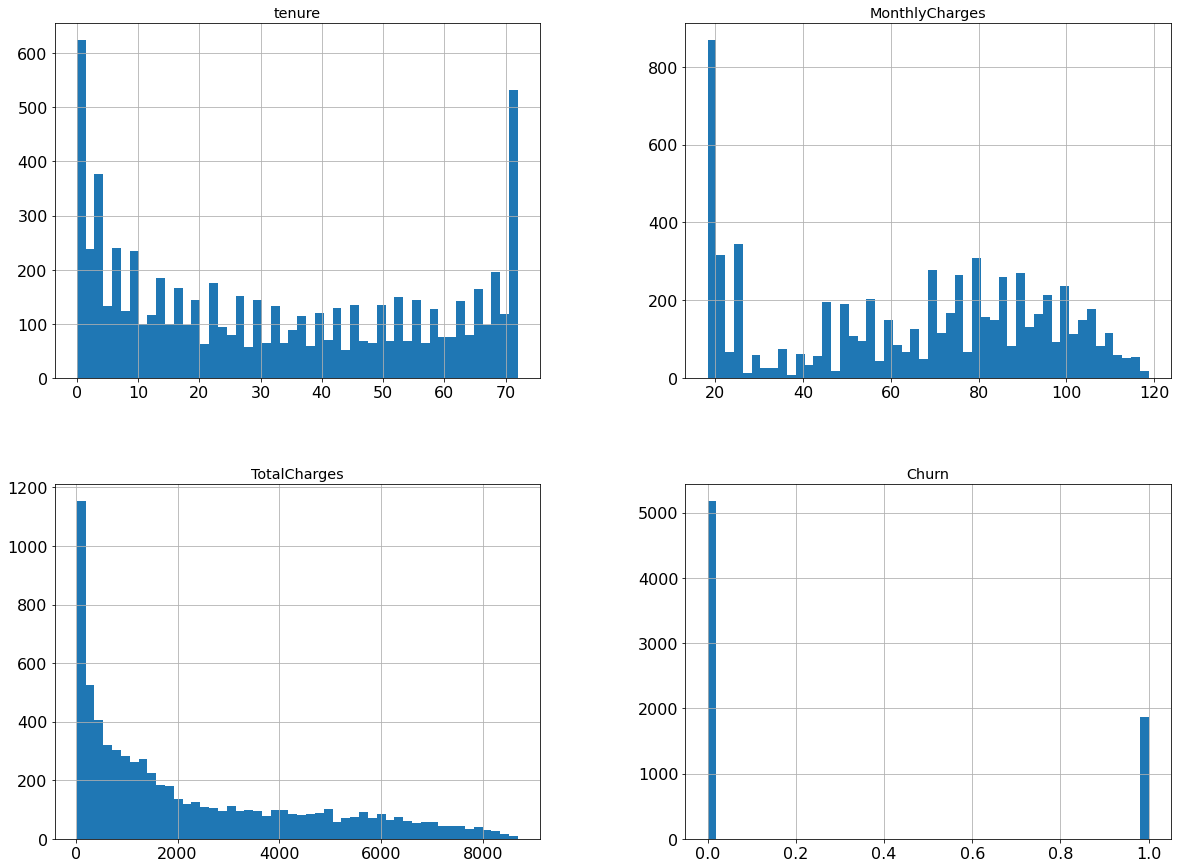

In [12]:
# plot histogram of the numeric features
telco.hist(bins=50, figsize=(20,15))
plt.show()

The tenure is a units of months, whislt the two charges fields are in the same currency unit.

The churn is made of two imbalanced classes: churn (1) or no churn (0).

In [13]:
telco.dtypes.value_counts()

object     17
int64       2
float64     2
dtype: int64

In [14]:
telco.select_dtypes(object).columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [15]:
# select the non-numeric features, excluding customerID and include churn
features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn']


In [16]:
# define a plotting function which shows the total value counts of each feature 
def plot_value_counts(df, column, i, j):  
    df[column].value_counts().plot.bar(ax=axs[i][j], figsize=(20,50), 
                                       title='{} counts'.format(column), rot=10)
 

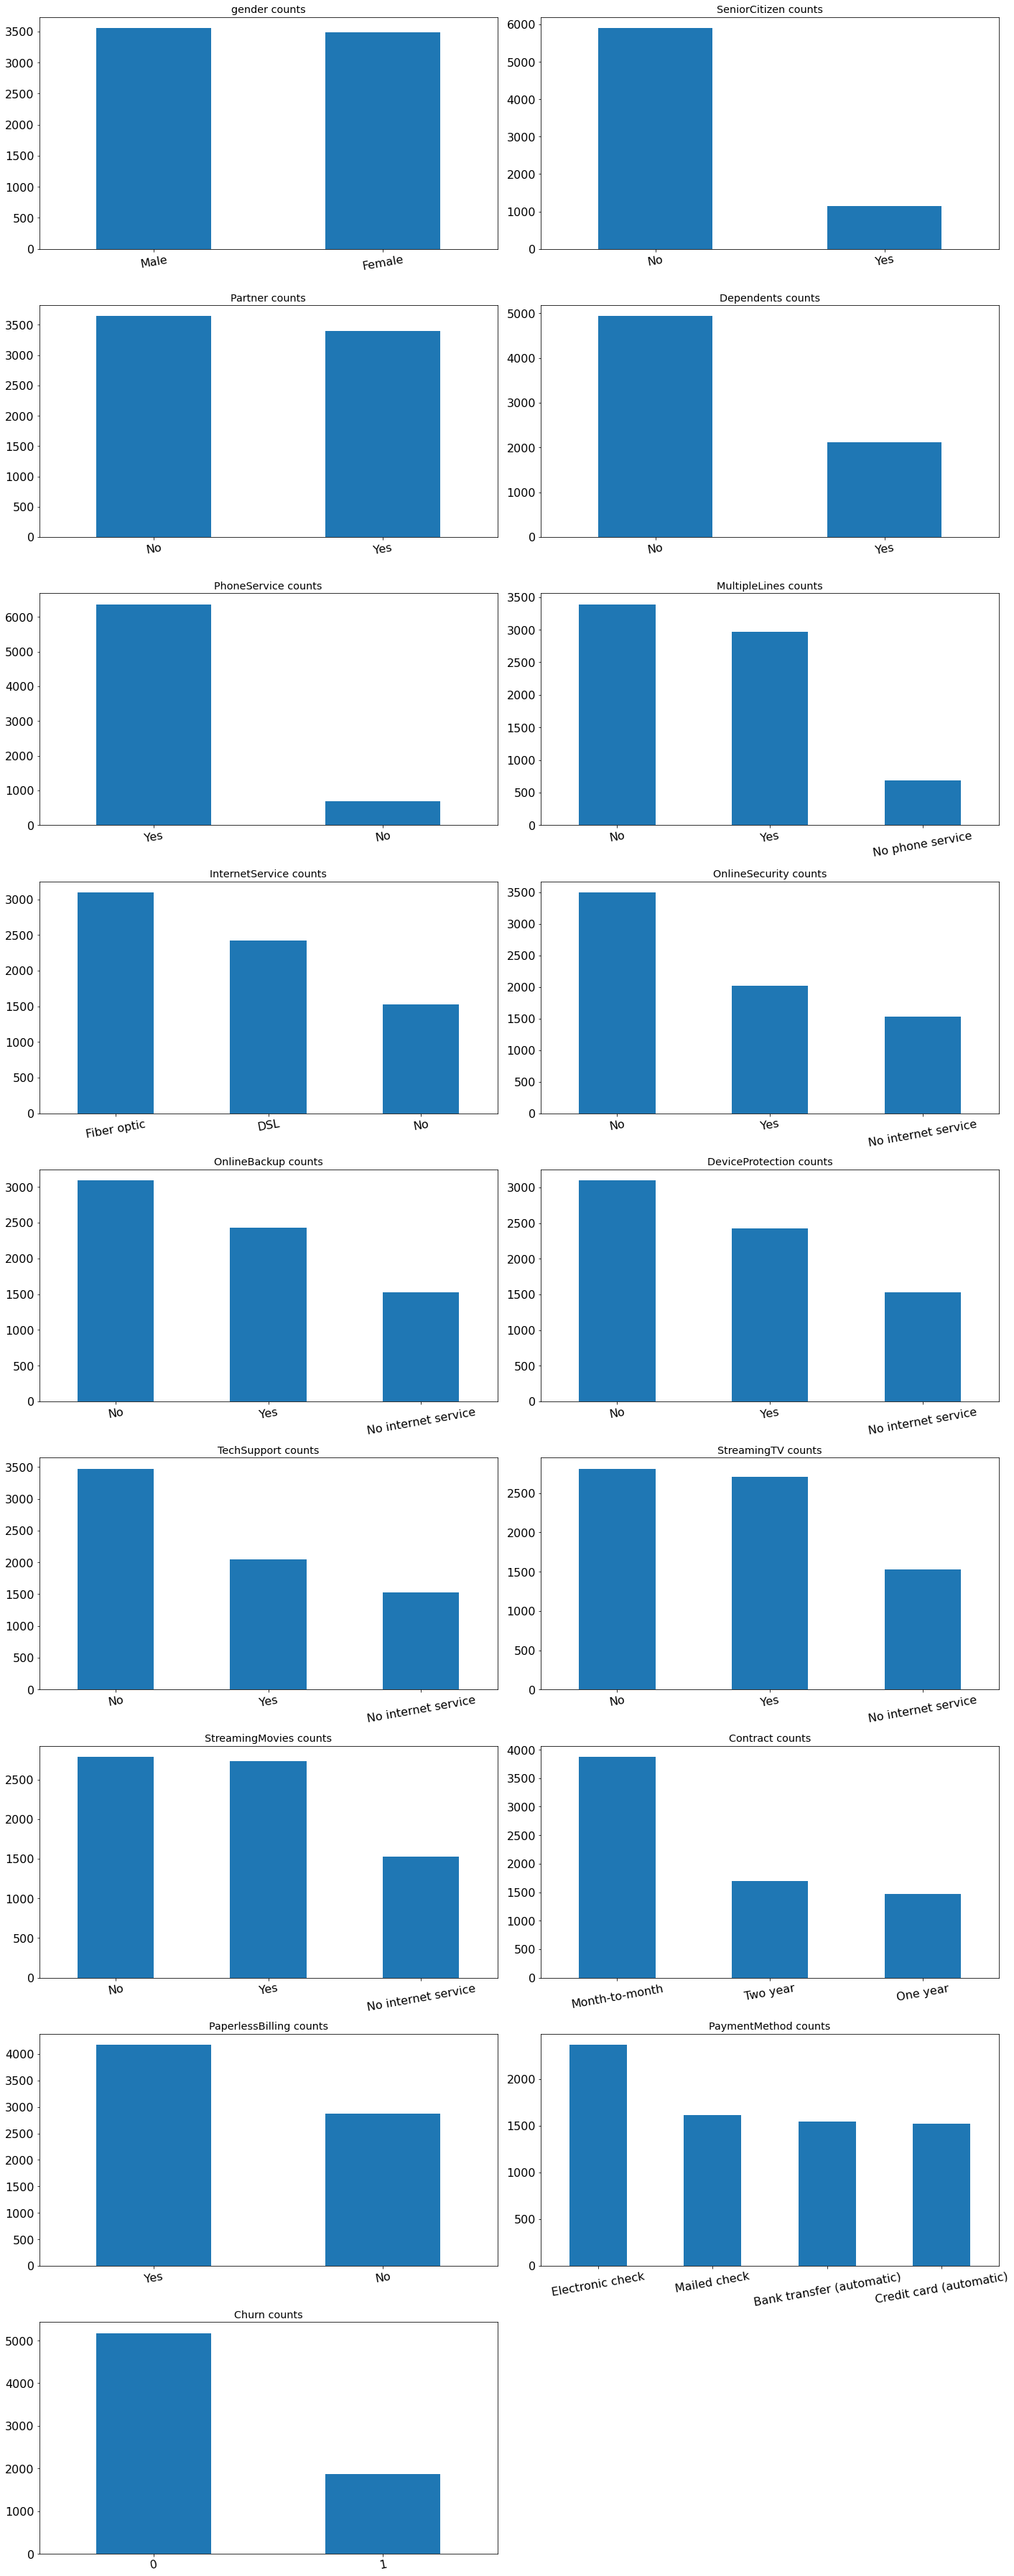

In [17]:
# plotting out non-numeric features and their values
cols = 2
rows = math.ceil(len(features)/2)


fig, axs = plt.subplots(rows, cols)

for i, col in enumerate(features):
    k = math.floor(i/2)
    if i % 2 == 0:
        plot_value_counts(telco, col, k, 0)
    else:
        plot_value_counts(telco, col, k, 1)

axs[-1, -1].axis('off')
plt.tight_layout()


The data looks fairly clean to begin with, which is good. There are some missing values in TotalCharges which I will fix later on.

### 2b. Create Train Test Split

### 2bi. Stratified Sampling

In [18]:
# use stratified sampling to ensure train and test contain the target variable in the same proportion

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=5)
for train_index, test_index in split.split(telco, telco['Churn']):
    strat_train_set = telco.loc[train_index]
    strat_test_set = telco.loc[test_index]

In [19]:
strat_train_set.shape

(5634, 21)

In [20]:
strat_test_set.shape

(1409, 21)

In [21]:
telco['Churn'].value_counts()/len(telco)

0    0.73463
1    0.26537
Name: Churn, dtype: float64

In [22]:
strat_train_set['Churn'].value_counts()/len(strat_train_set)

0    0.734647
1    0.265353
Name: Churn, dtype: float64

In [23]:
strat_test_set['Churn'].value_counts()/len(strat_test_set)

0    0.734564
1    0.265436
Name: Churn, dtype: float64

The split here was stratified so the proportion of Yes and No Churn is the same as in the overall data, correct to 3sf.

## 2c. Take a baseline model 

In [24]:
# Fit model using a single feature MonthlyCharges
X_train_1 = strat_train_set[['MonthlyCharges']]
X_test_1 = strat_test_set[['MonthlyCharges']]

y_train = strat_train_set[['Churn']]
y_test = strat_test_set[['Churn']]

model_base = LogisticRegression(random_state=5)
model_base.fit(X_train_1, y_train)

LogisticRegression(random_state=5)

In [25]:
# Find prediction and probabilities for test set
y_pred_test = model_base.predict(X_test_1)
p_pred_test = model_base.predict_proba(X_test_1)[:, 1]

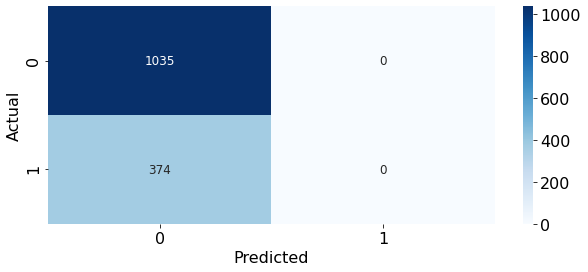

AUC: 0.5937818078483041
Accuracy 0.7345635202271115
Precision 0.0
Recall 0.0
F1 Score: 0.0


In [26]:
# Calculate other metrics for the test set
initial_evaluation(y_test, y_pred_test, p_pred_test)

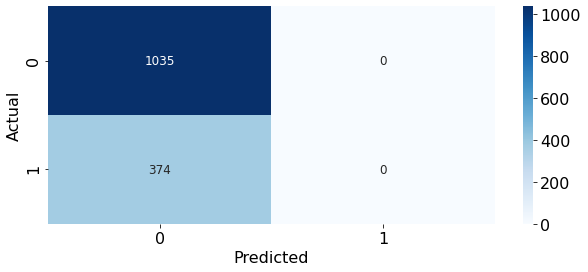

AUC: 0.5
Accuracy 0.7345635202271115
Precision 0.0
Recall 0.0
F1 Score: 0.0


In [27]:
# Evaluate even dumb model where we always predict the majority class: they will not churn
y_pred_dumb = np.zeros_like(y_test)

initial_evaluation(y_test, y_pred_dumb, y_pred_dumb)

This 'will never churn' dumb model is predicting the same as the simple single feature model we trained in the step prior.

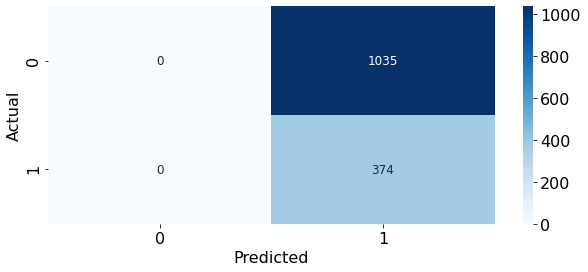

AUC: 0.5
Accuracy 0.2654364797728886
Precision 0.2654364797728886
Recall 1.0
F1 Score: 0.4195176668536175


In [28]:
# Evaluate even dumb model where we always predict the minority class: they will churn
y_pred_dumb = np.ones_like(y_test)

initial_evaluation(y_test, y_pred_dumb, y_pred_dumb)

A dumb model that only predicts no churn could be right 73% of the time in terms of accuracy.

## 3. Discover and Visualise to Gain Insights

In [29]:
# leave the test dataset aside now until the very end, and only visualise the train dataset
telco = strat_train_set.copy()
telco.shape

(5634, 21)

### 3a. Looking for Correlations

In [30]:
# only measures linear correlations, may miss other non-linear relationships
corr_matrix = telco.corr()

In [31]:
corr_matrix

,tenure,MonthlyCharges,TotalCharges,Churn
tenure,1.000000,0.241974,0.824548,-0.347036
MonthlyCharges,0.241974,1.000000,0.647050,0.203678
TotalCharges,0.824548,0.647050,1.000000,-0.195354
Churn,-0.347036,0.203678,-0.195354,1.000000


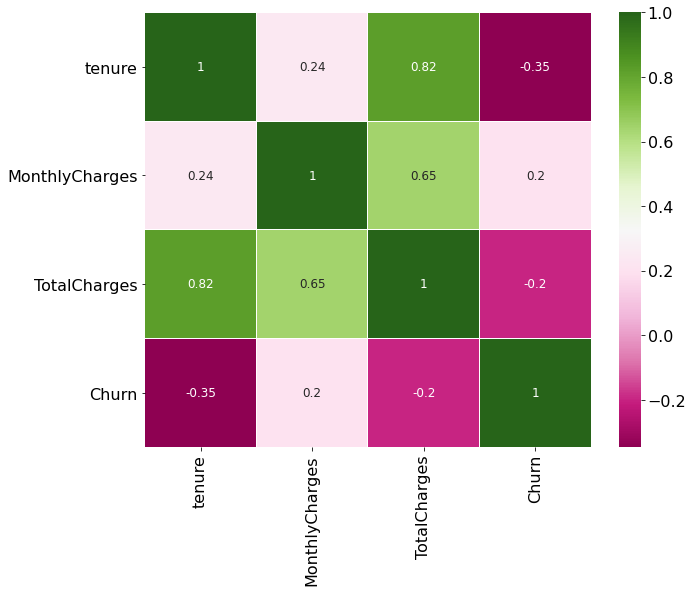

In [32]:
sns.heatmap(telco.corr(),annot=True,cmap='PiYG',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

- Total Charges and Tenure are highly positively correlated with one another, as expected.
- Total Charges and Monthly Charges are are highly postively correlated with one another.
- Churn is negatively correlated with tenure- as tenure increases, churn decreases.

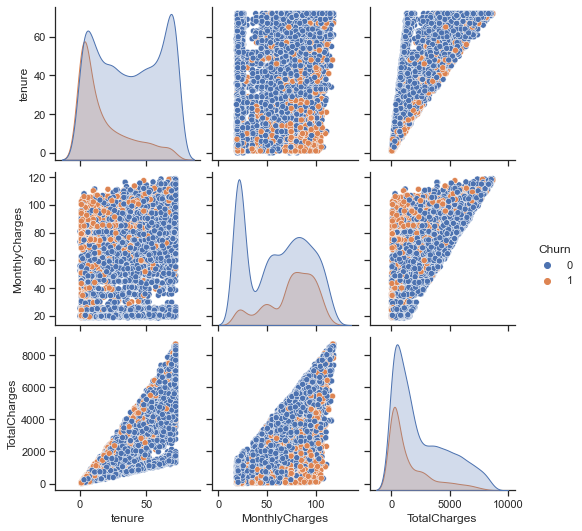

In [33]:
sns.set(style="ticks", color_codes=True)

sns.pairplot(telco, hue="Churn")

- There is a positive fan shaped correlation between total charges and tenture.
- Those on shorter tenures look more likely to churn. 
- Those with high monthly charges look more likely to churn.
- Those who do churn, tend to have lower total charges.
- Those with high tenture and low total charges do seem to be likley to not churn.

### 3b. Further EDA

In [34]:
# As before, select the categorical features
features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

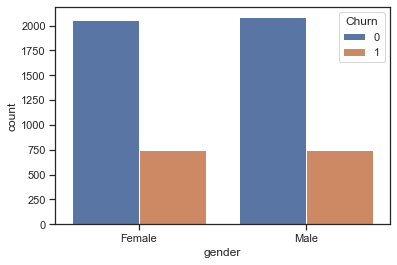

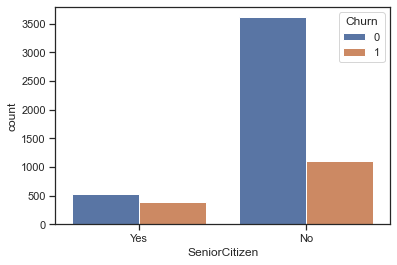

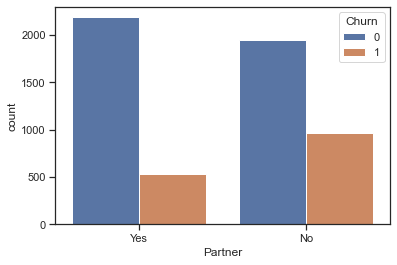

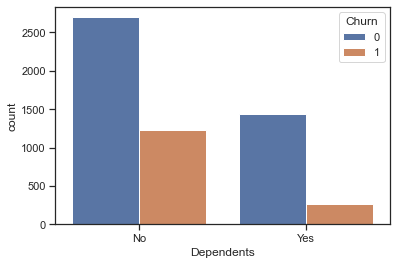

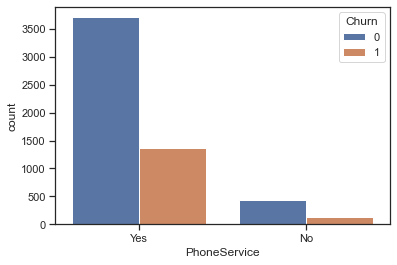

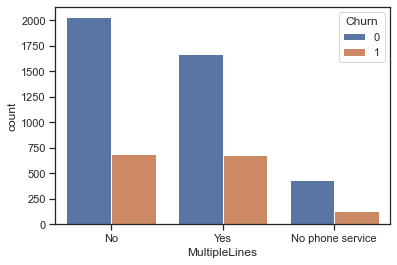

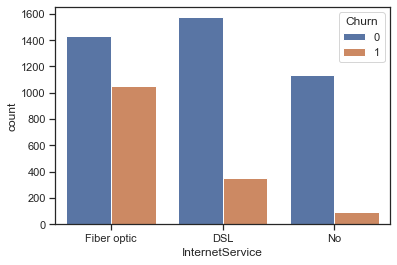

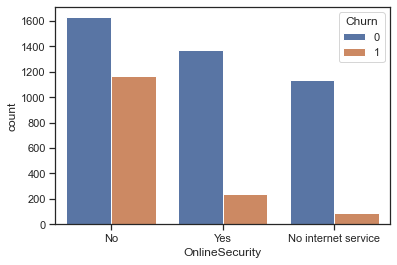

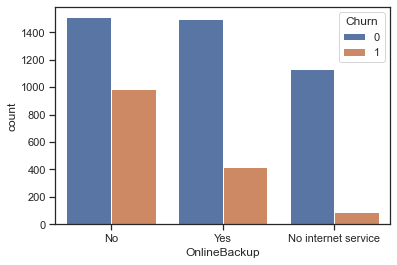

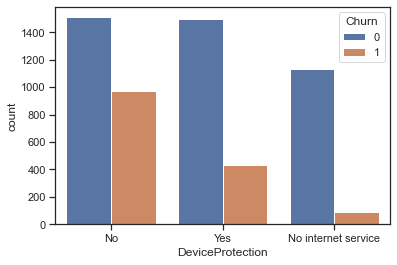

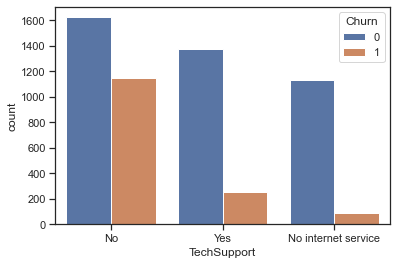

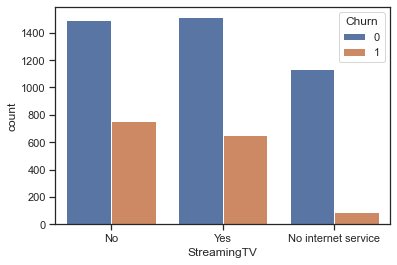

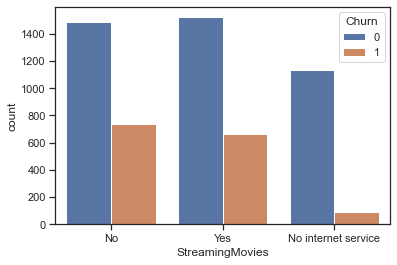

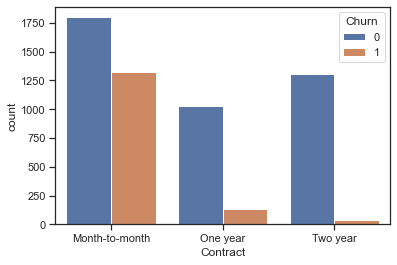

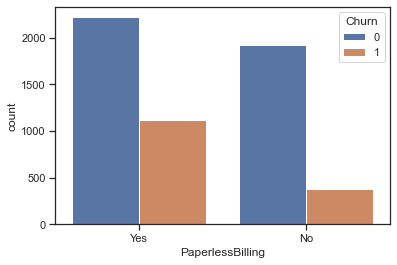

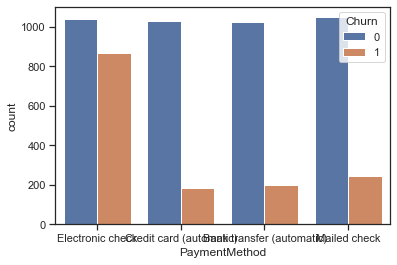

In [35]:
for i, feature in enumerate(features):
    plt.figure(i)
    sns.countplot(feature,hue='Churn',data=telco)

1. Churn: there isn't any 1 gender more likely to churn. Volumes of male and female are similar overall.

2. Senior Citizen: whilst there are about 5 times less seniors than non-senior, they are x2 more likely to churn than non-seniors.

3. Partner: having 'no' partner vs 'yes' makes someone x2 more likely to churn.

4. Dependents: having dependents makes someone x3 less likely to churn.

5. Phone Service: this doesn't seem to have an impact on churn.

6. Multiple Lines: having multiple lines does seems to increase chance of churn slightly but overall not significantly.

7. Internet Service: having Fiber optic makes someone x3 likely to churn vs someone on DSL vs no internet.

8. Online Security: having no online security makes someone x5-6 more likely to churn than those with it and those with no internet

9. Online Backup: having no backup makes someone x2 more likely to churn.

10. Device Protection: similar to online back up

11. Tech Support: x4 more likely to churn with no support

12. Streaming TV: slighly more likely to churn with no tv

13. Streaming Movies: similar to tv

14. Contract: month to month contracts x5 more likely to churn

15. Paperless billing: paperless x2 more likely to churn

16. Payment method: Electronic cheque payers x3-4 more likely to chrun

## 4.Prepare Data for ML Algorithms

In [36]:
# prepare the training data set for model training by seperating features and labels
telco = strat_train_set.drop('Churn', axis=1)
telco_labels = strat_train_set['Churn'].copy()

In [37]:
# seperate numerical and categorical features by dtypes
telco_num = telco.select_dtypes(include=[np.number])
telco_cat = telco.select_dtypes(include=[np.object])
print('Telco shape: {}'.format(telco.shape))
print('Telco numeric shape: {}'.format(telco_num.shape))
print('Telco categorical shape: {}'.format(telco_cat.shape))

Telco shape: (5634, 20)
Telco numeric shape: (5634, 3)
Telco categorical shape: (5634, 17)


In [38]:
telco_num.head(2)

,tenure,MonthlyCharges,TotalCharges
3031,50,71.05,3444.85
4569,22,48.80,1054.60


In [39]:
telco_cat.head(2)

,customerID,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
3031,3923-CSIHK,Female,Yes,Yes,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
4569,7639-SUPCW,Female,No,No,No,Yes,No,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic)


### 4a. Data Cleaning

- Fix or remove outliers (optional).

- Fill in missing values (e.g., with zero, mean, median…) or drop their rows (or columns).

In [40]:
telco.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        9
dtype: int64

Only TotalCharges has null values and no outliers were seen during EDA.

In [41]:
# filling median where null. This will be carried out in pipeline later on too,
imputer = SimpleImputer(strategy='median')
imputer.fit(telco_num)

SimpleImputer(strategy='median')

In [42]:
X = imputer.transform(telco_num) 

### 4b. Feature selection
- Drop the attributes that provide no useful information for the task.

In [43]:
# dropping customerID column as I haven't explored that enough
# it might have some benefit but currently it is just a uid so I'll drop it
telco = telco.drop('customerID', axis=1)

# during EDA, found some variables which have not much impact to the propensity to churn on their own
telco = telco.drop(['gender','PhoneService','StreamingTV','StreamingMovies'], axis=1)

In [44]:
# rerun the num cat split, having had dropped some features in the previous step
telco_num = telco.select_dtypes(include=[np.number])
telco_cat = telco.select_dtypes(include=[np.object])
print('Telco shape: {}'.format(telco.shape))
print('Telco numeric shape: {}'.format(telco_num.shape))
print('Telco categorical shape: {}'.format(telco_cat.shape))

Telco shape: (5634, 15)
Telco numeric shape: (5634, 3)
Telco categorical shape: (5634, 12)


### 4c. Feature engineering
Options here:
- Discretize continuous features.

- Decompose features (e.g., categorical, date/time, etc.).

- Add promising transformations of features (e.g., log(x), sqrt(x), x2, etc.).

- Aggregate features into promising new features

#### 4ci. Dealing with categorial values: ordinal or one-hot encoding

In [45]:
# One-hot encoding the categorical features
cat_encoder = OneHotEncoder()

telco_cat_ohe = cat_encoder.fit_transform(telco_cat)
telco_cat_ohe 

<5634x33 sparse matrix of type '<class 'numpy.float64'>'
	with 67608 stored elements in Compressed Sparse Row format>

### 4d. Feature Scaling
- Standardize or normalize features.

a. Min-max scaling aka normilization is the simplest. Values are shifted and scaled to end up in the range 0 to 1.

b. Standardisation subtracts mean and divides by sd, so the distribution will have mean 0 and a sd 1. It is not bound by a specific range which could be a problem in neural nets. But is much less affected by outfliers.

In this project, I'll use standardisation using StandardScaler in pipeline.

### 4e. Transformation Pipelines

In [46]:
# define the numerical features transformation pipeline, taken from previous steps
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scalar', StandardScaler()),
])

In [47]:
# define the categorical features transformation pipeline, taken from previous steps
cat_pipeline = Pipeline([
    ("ohe", OneHotEncoder())
])

In [48]:
# we had dropped some features in the previous steps, so now this returns just the features I wanted to keep
print(list(telco_num))
print(list(telco_cat))

['tenure', 'MonthlyCharges', 'TotalCharges']
['SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [49]:
# run the tranformation pipelines using column transformer for the features selected
# if I wanted to keep any unlisted columns not to be dropped then I can set remainder to passthrough

num_attribs = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_attribs = ['SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService',
               'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
               'Contract', 'PaperlessBilling', 'PaymentMethod']

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs)
    ])

telco_prepared = full_pipeline.fit_transform(telco)

In [50]:
# inspect the ohe hot encoded created features
full_pipeline.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_attribs)

array(['SeniorCitizen_No', 'SeniorCitizen_Yes', 'Partner_No',
       'Partner_Yes', 'Dependents_No', 'Dependents_Yes',
       'MultipleLines_No', 'MultipleLines_No phone service',
       'MultipleLines_Yes', 'InternetService_DSL',
       'InternetService_Fiber optic', 'InternetService_No',
       'OnlineSecurity_No', 'OnlineSecurity_No internet service',
       'OnlineSecurity_Yes', 'OnlineBackup_No',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No', 'DeviceProtection_No internet service',
       'DeviceProtection_Yes', 'TechSupport_No',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_No', 'PaperlessBilling_Yes',
       'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check'],
      dtype=object)

In [51]:
telco_prepared.shape

(5634, 36)

## 5. Select and Train a Model

In [52]:
# split training data into a train and validation (written test here) features and labels
X_train, X_test, y_train, y_test = train_test_split(telco_prepared, telco_labels, random_state=5)

In [53]:
len(X_train)

4225

In [54]:
len(X_test)

1409

### Gaussian Naive Bayes:

In [55]:
gaussian = GaussianNB() 
gaussian.fit(X_train, y_train)  
y_pred = gaussian.predict(X_test)  

acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
test_acc_gaussian = round(metrics.accuracy_score(y_test, y_pred)*100, 2)

### Stochastic Gradient Descent (SGD):

In [56]:
sgd = SGDClassifier(max_iter=5, tol=None)
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
test_acc_sgd = round(metrics.accuracy_score(y_test, y_pred)*100, 2)

### Random Forest:

In [57]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
test_acc_random_forest = round(metrics.accuracy_score(y_test, y_pred)*100, 2)

### Logistic Regression:

In [58]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, y_train) * 100, 2)
test_acc_log = round(metrics.accuracy_score(y_test, y_pred)*100, 2)

### K Nearest Neighbor:

In [59]:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, y_train)  
y_pred = knn.predict(X_test)  

acc_knn = round(knn.score(X_train, y_train) * 100, 2)
test_acc_knn = round(metrics.accuracy_score(y_test, y_pred)*100, 2)

### Perceptron:

In [60]:
perceptron = Perceptron(max_iter=5)
perceptron.fit(X_train, y_train)
y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
test_acc_perceptron = round(metrics.accuracy_score(y_test, y_pred)*100, 2)

### Linear Support Vector Machine:

In [61]:
#linear_svc = LinearSVC()
linear_svc = SVC(kernel='linear',probability=True)
linear_svc.fit(X_train, y_train)
y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
test_acc_linear_svc = round(metrics.accuracy_score(y_test, y_pred)*100, 2)


### Decision Tree


In [62]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, y_train)  
y_pred = decision_tree.predict(X_test) 

acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
test_acc_decision_tree = round(metrics.accuracy_score(y_test, y_pred)*100, 2)

### XGBoost

In [63]:
xgb_classifier = XGBClassifier(random_state=5, n_estimators=500, learning_rate=0.05)
xgb_classifier.fit(X_train, y_train, early_stopping_rounds = 10,
                eval_set = [(X_test, y_test)], verbose = False)
y_pred = xgb_classifier.predict(X_test)

acc_xgb_classifier = round(xgb_classifier.score(X_train, y_train) * 100, 2)
test_acc_xgb_classifier = round(metrics.accuracy_score(y_test, y_pred)*100, 2)

### 5a. Using accuracy, which is the best model so far?

In [64]:
results = pd.DataFrame({
    'Model': ['Linear SVC', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree','XBG Classifier'],
    'Train Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree, acc_xgb_classifier],
    'Validation Score': [test_acc_linear_svc, test_acc_knn, test_acc_log, 
              test_acc_random_forest, test_acc_gaussian, test_acc_perceptron, 
              test_acc_sgd, test_acc_decision_tree, test_acc_xgb_classifier]})
result_df = results.sort_values(by='Train Score', ascending=False)
result_df = result_df.set_index('Train Score')
result_df.head(10)

,Model,Validation Score
Train Score,,
99.86,Random Forest,78.64
99.86,Decision Tree,72.53
86.70,KNN,75.80
84.02,XBG Classifier,81.48
80.97,Logistic Regression,80.41
80.02,Linear SVC,79.84
79.03,Stochastic Gradient Decent,78.35
71.31,Perceptron,70.40
71.15,Naive Bayes,72.04


Inspecting the training accuracy vs the validation accuracy, I can see some models are badly overfitting on the train where train accuracy is much higher than validation.

In [65]:
results = pd.DataFrame({
    'Model': ['Linear SVC', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree','XBG Classifier'],
    'Validation Score': [test_acc_linear_svc, test_acc_knn, test_acc_log, 
              test_acc_random_forest, test_acc_gaussian, test_acc_perceptron, 
              test_acc_sgd, test_acc_decision_tree, test_acc_xgb_classifier]})
result_df = results.sort_values(by='Validation Score', ascending=False)
result_df = result_df.set_index('Validation Score')
result_df.head(10)

,Model
Validation Score,
81.48,XBG Classifier
80.41,Logistic Regression
79.84,Linear SVC
78.64,Random Forest
78.35,Stochastic Gradient Decent
75.80,KNN
72.53,Decision Tree
72.04,Naive Bayes
70.40,Perceptron


Accuracy = correct predictions count / all predictions count
Accuracy is not the best metric to use as there is class imbalance, but it is good to get a first pass evaluation of how well a model is doing.

Our dumb model was 73% accurate, so Decision Tree, Naive Bayes and Perceptron are performing worse than that, and other models are marginally better.


### 5b. Evaluate using Cross-Validation

In [66]:
# use statified kfolds for cross validation to ensure churn proportions are maintained
kfold = StratifiedKFold(n_splits=5)

In [67]:
random_state = 5

# store each classifier in a list to loop over
classifiers = []

classifiers.append(SGDClassifier(random_state=random_state, max_iter=5, tol=None))
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state,n_estimators=100))
classifiers.append(SVC(random_state=random_state,kernel='linear',probability=True))
classifiers.append(GaussianNB())
classifiers.append(KNeighborsClassifier(n_neighbors = 3))
classifiers.append(Perceptron(random_state=random_state,max_iter=5))
classifiers.append(XGBClassifier(random_state=random_state, n_estimators=500, learning_rate=0.05))

cv_results = []
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall'}

# run cross validation for each classifier and store the scores in cv results
for classifier in classifiers :
    cv_results.append(cross_validate(classifier, telco_prepared, telco_labels,scoring = scoring,
                                      cv = kfold, return_train_score=True))

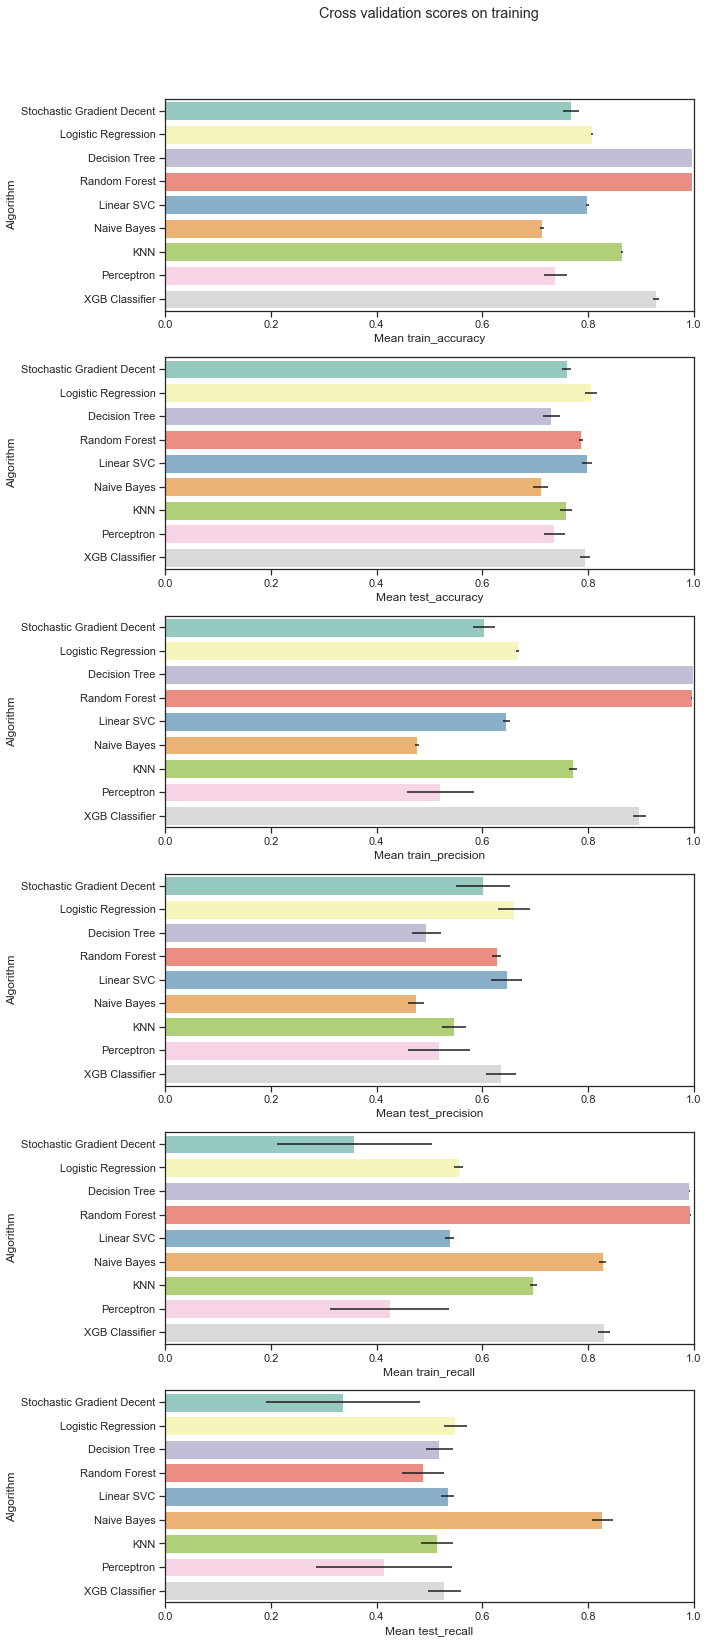

In [68]:
scoring_metrics = ['train_accuracy', 'test_accuracy', 'train_precision','test_precision','train_recall','test_recall']

fig, ax =plt.subplots(6,1, figsize=(10,24))


for i, metric_name in enumerate(scoring_metrics):
    models_scores = [model[metric_name] for model in cv_results]
    cv_means = []
    cv_std= []
    for model_scores in models_scores:
        cv_means.append(model_scores.mean())
        cv_std.append(model_scores.std())

    cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":[
    "Stochastic Gradient Decent","Logistic Regression","Decision Tree","Random Forest", "Linear SVC",
    "Naive Bayes","KNN","Perceptron", "XGB Classifier"]})
    
    g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std},
                   ax=ax[i])
    g.set_xlabel("Mean {}".format(metric_name))
    ax[i].set_xlim(0,1)

    mid = (fig.subplotpars.right + fig.subplotpars.left)/2
    fig.suptitle('Cross validation scores on training', x=mid)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])

Cross validation allows you to get an estimate of the model performance and also a measure of how precise the estimate is (the sd) as plotted above.

If the score on the training set is much lower than on validation sets, then the model is still overfitting. This is the case with Deicsion Tree, Random Forest, KNN and XGB.

Possible solutions to overfitting are to simplify the model, constrain it (i/e regularize it), or get a lot more training data. Regularization is controlled by hyperparameters, so in this step we won't be doing that. This step is to short list some promising models.

As the aim of the project is to identify potential churners before they churn, in order to attempt to retain them, so a **high recall** (being able to spot a high amount of potential churners) is important. 

Whilst having a **low precision** (stating some non-churners might churn) wouldn't be damaging to the customer experience, depending on what promotion is offered to those identified as churners, we could lose revenue unnecessarily if non-churner recommit on a lower tarrif. 

So we should still try to balance the benefit of high recall vs downsides of low precision.

Short listed models: Linear SVC, Logistic Regression, Naive Bayes.

## 6. Hyperparameter Tuning

### 6a. Randomised Search

In [69]:
# instantiate pipeline
pipe = Pipeline([('classifier' , LogisticRegression())
                ])
# define cross validator splits as 5 and repeat 3 times
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=5)

# define the hyperparameter ranges
param_distribs = [
    {'classifier' : [LogisticRegression(random_state=random_state)],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : loguniform(1e-5, 100),
    'classifier__solver' : ['liblinear']},
    {'classifier' : [SVC(random_state=random_state,kernel='linear',probability=True)],
   # 'classifier__gamma' : [0.1, 1, 10, 100],
    'classifier__C' : loguniform(1e-5, 100)
    },
    {'classifier' : [GaussianNB()],
        'classifier__var_smoothing': loguniform(1e-9, 1) }
]

# run randomized search
random_search = RandomizedSearchCV(pipe, param_distribs, cv=5,
                          scoring='recall', n_jobs=-1, n_iter = 10, random_state=5, verbose=1)

random_search.fit(telco_prepared, telco_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.6s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('classifier',
                                              LogisticRegression())]),
                   n_jobs=-1,
                   param_distributions=[{'classifier': [LogisticRegression(random_state=5)],
                                         'classifier__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a242b0550>,
                                         'classifier__penalty': ['l1', 'l2'],
                                         'classifier__solver': ['liblinear']},
                                        {'classifier': [SVC(kernel='linear',
                                                            probability=True,
                                                            random_state=5)],
                                         'classifier__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a21e3f438>},
                                        {'classifier': [GaussianNB(var_smo

In [70]:
cvres = random_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)


0.8327759197324415 {'classifier': GaussianNB(var_smoothing=0.06864213065897411), 'classifier__var_smoothing': 0.06864213065897411}
0.8274247491638796 {'classifier': GaussianNB(var_smoothing=0.06864213065897411), 'classifier__var_smoothing': 1.8777253692555264e-06}
0.5317725752508361 {'classifier': SVC(kernel='linear', probability=True, random_state=5), 'classifier__C': 0.02623483406064879}
0.8294314381270903 {'classifier': GaussianNB(var_smoothing=0.06864213065897411), 'classifier__var_smoothing': 0.007819350997633114}
0.8274247491638796 {'classifier': GaussianNB(var_smoothing=0.06864213065897411), 'classifier__var_smoothing': 2.397408118779801e-05}
0.010033444816053512 {'classifier': LogisticRegression(random_state=5), 'classifier__C': 0.0002060860525256664, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
0.5505016722408026 {'classifier': LogisticRegression(random_state=5), 'classifier__C': 5.448908954539915, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinea

In [71]:
# summarize result
print('Best Score: %s' % random_search.best_score_)
print('Best Hyperparameters: %s' % random_search.best_params_)

Best Score: 0.8327759197324415
Best Hyperparameters: {'classifier': GaussianNB(var_smoothing=0.06864213065897411), 'classifier__var_smoothing': 0.06864213065897411}


Randomized search can provided a good starting point for defining the hyperparameter space for grid search.

### 6b. Grid Search

In [72]:
# instantiate pipeline
pipe = Pipeline([('classifier' , GaussianNB())
                ])
# define cross validator splits as 5 and repeat 3 times
#cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=5)
# this was taking a long time to run so repeats weren't carried out
cv = StratifiedKFold(n_splits=5, random_state=5)

# define the hyperparameter space
param_grid = [
    {'classifier' : [LogisticRegression(random_state=random_state)],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : [0.1, 10, 1000],
    'classifier__solver' : ['liblinear']},
    {'classifier' : [SVC(random_state=random_state)],
    #'classifier__gamma' : [0.1, 1, 10, 100],
    'classifier__C' : [0.1,10, 1000],
     'classifier__kernel': ['linear']},
    {'classifier' : [GaussianNB()],
     'classifier__var_smoothing': [1e-9, 1e-5, 1] }  
]
# run grid search
grid_search = GridSearchCV(pipe, param_grid,
                          scoring='recall', n_jobs=-1, verbose=1)

grid_search.fit(telco_prepared, telco_labels)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  1.4min finished


GridSearchCV(estimator=Pipeline(steps=[('classifier', GaussianNB())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(random_state=5)],
                          'classifier__C': [0.1, 10, 1000],
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear']},
                         {'classifier': [SVC(random_state=5)],
                          'classifier__C': [0.1, 10, 1000],
                          'classifier__kernel': ['linear']},
                         {'classifier': [GaussianNB()],
                          'classifier__var_smoothing': [1e-09, 1e-05, 1]}],
             scoring='recall', verbose=1)

### 6c. Analyse the Best Models Performance

In [73]:
# summarize result
print('Best Score: %s' % grid_search.best_score_)
print('Best Hyperparameters: %s' % grid_search.best_params_)

Best Score: 0.8274247491638796
Best Hyperparameters: {'classifier': GaussianNB(), 'classifier__var_smoothing': 1e-09}


In [74]:
best_model  = pipe.set_params(**grid_search.best_params_).fit(telco_prepared, telco_labels)

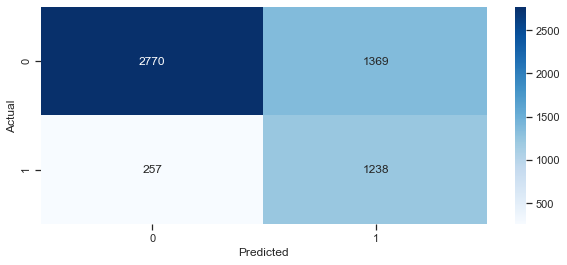

Accuracy: 0.711395101171459
Precision: 0.4748753356348293
Recall: 0.8280936454849498
F1 Score: 0.6036079960994636


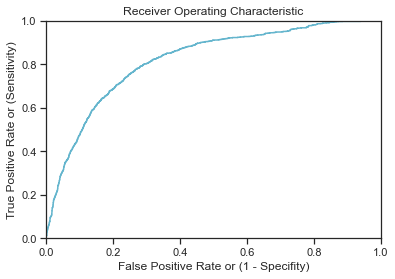

AUC: 0.8181908608949376


In [75]:
# run evaluation of the best model returned via grid search
classification_evaluation(best_model, telco_prepared, telco_labels, cv=3)

Compared of the simple and dumb models, performance is better. This model produces a high recall, albiet not great precision nor accuracy.

### 6d. Feature Importance in LogReg Best Model

In [76]:
# to guide me in improving the feature selection and engineering, I will look at the feature importance
# within the logistic regression model
pipe = Pipeline([('classifier' , GaussianNB())
                ])
param_grid = [
    {'classifier' : [LogisticRegression(random_state=random_state)],
     'classifier__penalty' : ['l1', 'l2'],
    'classifier__C' : [0.1, 10, 1000],
    'classifier__solver' : ['liblinear']}, 
]

grid_search = GridSearchCV(pipe, param_grid,
                          scoring='recall', n_jobs=-1, verbose=1)

grid_search.fit(telco_prepared, telco_labels)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    0.6s finished


GridSearchCV(estimator=Pipeline(steps=[('classifier', GaussianNB())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(C=1000,
                                                            random_state=5,
                                                            solver='liblinear')],
                          'classifier__C': [0.1, 10, 1000],
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear']}],
             scoring='recall', verbose=1)

In [77]:
feature_coefs = grid_search.best_estimator_.named_steps['classifier'].coef_[0]
feature_coefs.shape

(36,)

In [78]:
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(full_pipeline.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_attribs))
attributes = num_attribs +  cat_one_hot_attribs
print(len(attributes))
importances = sorted(zip(feature_coefs, attributes), reverse=True)

36


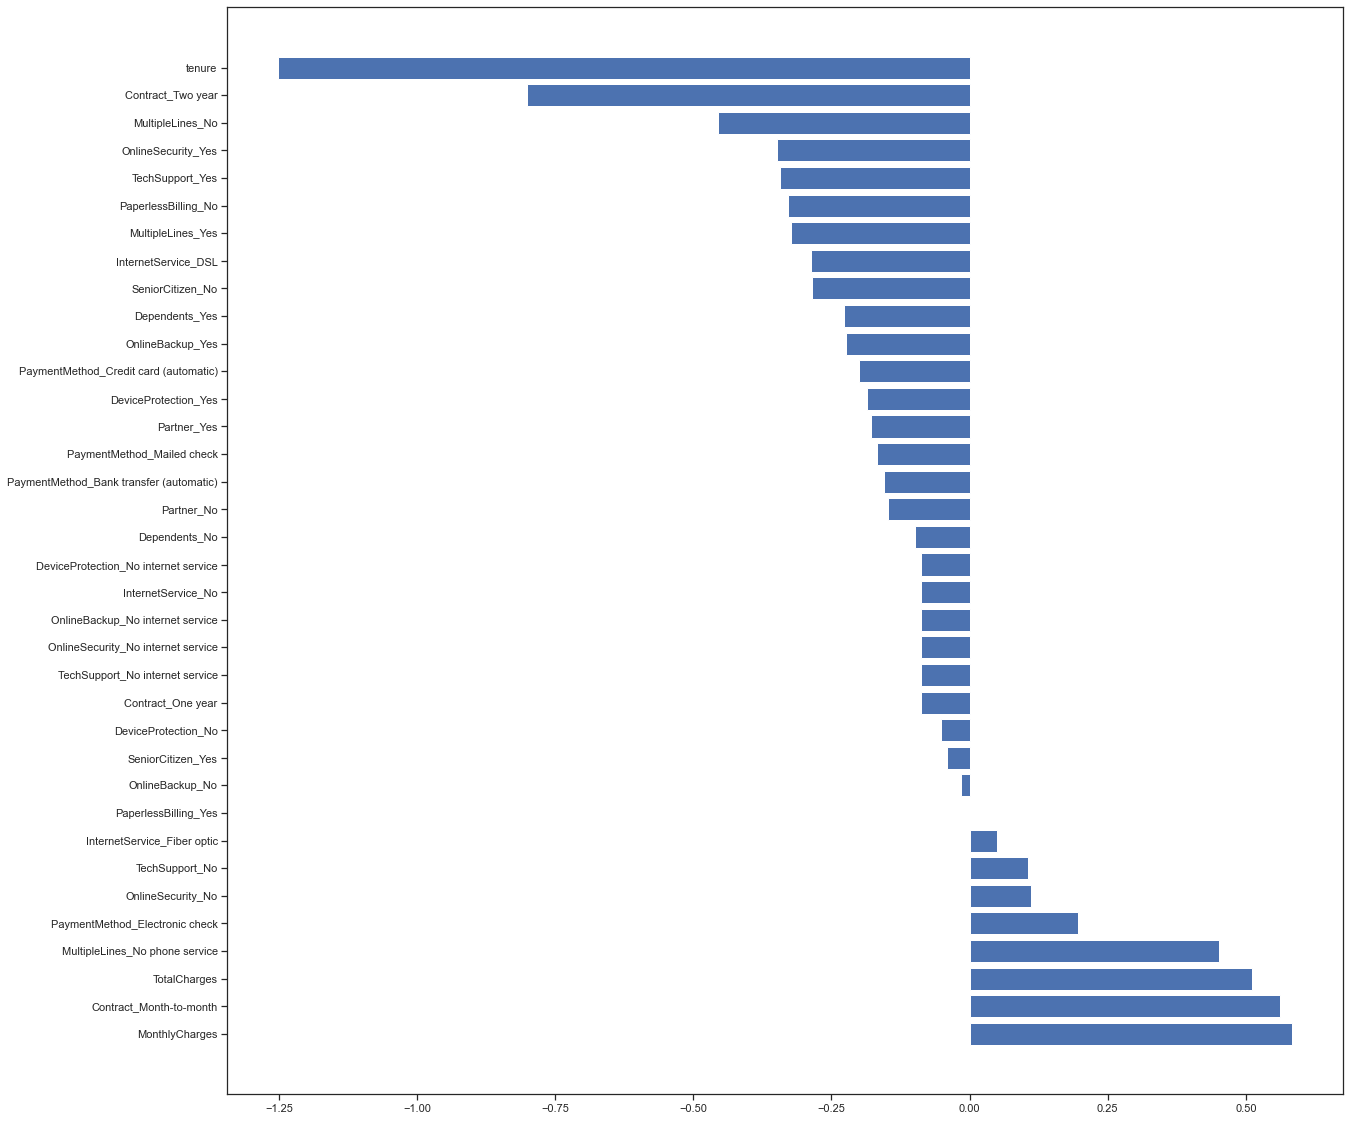

In [79]:
x = [tup[1] for tup in importances]
y = [tup[0] for tup in importances]

plt.figure(figsize=(20,20))
plt.barh(x, y)
plt.show()

With this information, I can go back to drop some less useful features, do more feature engineering, drop any outliers I has not seen before etc.

### 6e. Evaluate on the Test Set

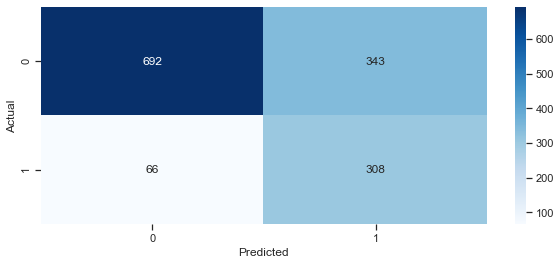

Accuracy 0.7097232079489
Precision 0.4731182795698925
Recall 0.8235294117647058
F1 Score: 0.6009756097560977


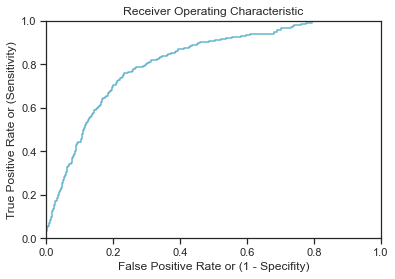

AUC: 0.8166937921413625


In [80]:
# retrieve the test dataset we had held out for the very end
X_test_prepared = full_pipeline.transform(strat_test_set) #only run transform and not fit
y_test = strat_test_set['Churn'].copy()
final_predictions = best_model.predict(X_test_prepared)
final_evaluation(best_model, X_test_prepared, y_test)

Performance on the test dataset is actually quite similar to the cross validated train results, indicating I haven't overfit to the training dataset which is positive.

### 6ei. Business Evaluation of Best Model

Other than the model performance metrics, business context performance is important too.

One way to determine performance here could be to see, when offering both groups discounts to their tarriffs:
- revenue retained from potential churner customers who had been correctly identified
- vs revenue lost from non-churners customer who had been incorrectly identified as churners



In [81]:
eval_df = strat_test_set[['customerID', 'MonthlyCharges', 'Contract', 'Churn']]
eval_df['Prediction'] = final_predictions.copy()

In [82]:
eval_df.head()

,customerID,MonthlyCharges,Contract,Churn,Prediction
4187,2642-MAWLJ,20.25,Two year,0,0
638,4913-EHYUI,104.55,One year,1,0
2791,1023-BQXZE,74.35,Two year,0,0
1607,4154-AQUGT,89.05,Month-to-month,1,1
2666,8414-OOEEL,79.50,Two year,0,0


In [83]:
# assess volumes of actual churners and their contracts
table = pd.pivot_table(eval_df, values='Churn', index=['Contract'], aggfunc=np.sum)
table

,Churn
Contract,
Month-to-month,333
One year,32
Two year,9


In [84]:
# assess volumes of predicted churners and their contracts
table = pd.pivot_table(eval_df, values='Prediction', index=['Contract'], aggfunc=np.sum)
table

,Prediction
Contract,
Month-to-month,620
One year,31
Two year,0


In [85]:
# seperate true positive predictions
true_positives = eval_df[(eval_df['Churn'] == 1) & (eval_df['Prediction'] == 1) ]
true_positives.shape

(308, 5)

In [86]:
# seperate false positive predictions
false_positives = eval_df[(eval_df['Churn'] == 0) & (eval_df['Prediction'] == 1) ]
false_positives.shape

(343, 5)

In [87]:
print('Total Revenue of Churners targetted: £{:.2f}'.format(true_positives['MonthlyCharges'].sum()))

Total Revenue of Churners targetted: £22920.60


In [88]:
print('Total Revenue of Non-Churners targetted: £{:.2f}'.format(false_positives['MonthlyCharges'].sum()))

Total Revenue of Non-Churners targetted: £25311.30


### Business Evaluation Summary
In a campaign to retain revenue of customers identified as at risk of churning, we might offer each targetted customer a 10% discount to recontract to a 2 year contract, so that:

- if they are paying month to month:
    - this would decrease their churn risk going forward as they move out of month to month, which was identified as an important motivator to churn, and move them into a 2 year contract which is a motivator to not churn (due to early cancellation fees)

- if they are already in a 1 or 2 year contracts: 
    - this would reduce their churn risk too, by decreasing monthly charges, which was a significant movitator to churn 
    
Assuming that 80% of potential churners (i.e the true positive target group) decide to recontract, we would retain (roughly): £16,503.

Meanwhile, assuming that 100% of the non-churners (i.e the false positive target group) also decided to recontract, we would have uncecessarily lost: £2,531.13.

However overall, implementing a campaign based on this model's results would net in: **£13,971.87 retained**, which is 61% of the total revenue we would have lost if all potential churners did actually churn, without using this model.

## 7. Deploy Model

This model can be saved using the joblib library.

In [89]:
joblib.dump(best_model, 'churn_model.pkl')

['churn_model.pkl']

In [90]:
# load model
churn_model = joblib.load('churn_model.pkl')

new_data = pd.read_csv('datasets/telco/WA_Fn-UseC_-Telco-Customer-Churn.csv')
new_data['SeniorCitizen'].replace({1:'Yes', 0:'No'}, inplace=True)
new_data['TotalCharges'] = new_data.TotalCharges.replace(' ', np.nan)
new_data['TotalCharges'] = new_data.TotalCharges.astype('float')

# in reality, the new dataset will be different to the data previously used
# it then needs to run through preparation using full_pipeline.transform
X_prepared = full_pipeline.transform(new_data)

#run model for new predictions
predictions = churn_model.predict(X_prepared)

In [91]:
# export predictions with the customer id
results = new_data[['customerID']]
results['Prediction'] = predictions.copy()
results.to_csv('results/telco_churn_predictions.csv', index=False)
results.head()

,customerID,Prediction
0,7590-VHVEG,1
1,5575-GNVDE,0
2,3668-QPYBK,1
3,7795-CFOCW,0
4,9237-HQITU,1


## 8. Future improvements

In order to improve performance for the future, I could do the following:
- amend feature engineering; test out min-max scaling (normalization) instead of just using standardization
- more feature engineering, creating new features through a combination of one or more features
- amend feature selection; I had dropped out some features which didn't look overly important on first glance, but maybe could have been valuable to keep. 
    - Knowledge gained in the feature importance in section 6d. will enable me to select the best features to keep too
    - Principle Component Analysis or Linear Discriminant Analysis could be used to select features 
- inspect for and deal with outliers, which is something not done so far
- more hyperparameter tuning; using more compute resource I could increase my hyperparameter space on which to search
- use ensemble methods like bagging (bootstrap aggregating) or boosting for better overall performance